## Multimodal Deep Learning Exercise 1 

Deep learning models learn hierarchical features. Each layer can be seen as performing a coordinate transformation. Non-linear activations allow these transformations to "unfold" the data manifold. In this exercise, you will implement and visualize this
process using a simple dataset and a Multi-Layer Perceptron (MLP).

Insert your code wherever you see ``` # TODO:``` 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [30]:
###################################
##### Do not modify this code #####
###################################

def generate_3d_spirals(n_points_per_class=500, noise=0.2):
    """Generates two intertwined 3D spirals."""
    # Spiral 1
    theta1 = np.sqrt(np.random.rand(n_points_per_class)) * 3 * np.pi # angle
    r1 = theta1 + noise * np.random.randn(n_points_per_class) # radius variation
    x1 = r1 * np.cos(theta1)
    y1 = r1 * np.sin(theta1)
    z1 = theta1 * 0.5 + noise * np.random.randn(n_points_per_class) # z increases with angle
    class1 = np.zeros(n_points_per_class)

    # Spiral 2 (offset phase and direction)
    theta2 = np.sqrt(np.random.rand(n_points_per_class)) * 3 * np.pi # angle
    r2 = theta2 + noise * np.random.randn(n_points_per_class) # radius variation
    x2 = -r2 * np.cos(theta2) # Negate to interwine
    y2 = -r2 * np.sin(theta2) # Negate to interwine
    z2 = theta2 * 0.5 + noise * np.random.randn(n_points_per_class) # z increases with angle
    class2 = np.ones(n_points_per_class)

    # Combine
    X = np.vstack((np.column_stack((x1, y1, z1)), np.column_stack((x2, y2, z2))))
    y = np.concatenate((class1, class2))

    # Shuffle
    idx = np.random.permutation(len(y))
    X, y = X[idx], y[idx]

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

###################################
###################################


In [31]:
# Generate data
X, y = generate_3d_spirals(n_points_per_class=500, noise=0.05)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data shape:", X_train.shape)
print("Labels shape:", y_train.shape)

# Move data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)



Data shape: torch.Size([800, 3])
Labels shape: torch.Size([800, 1])


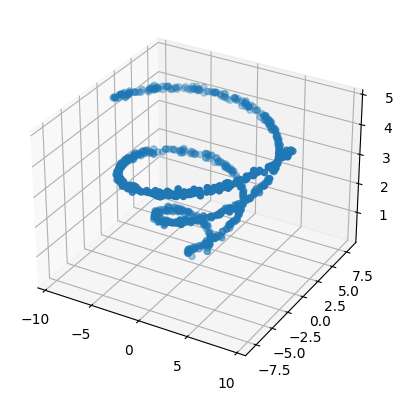

In [32]:
# TODO: Visualize in a 3D scatter plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2])

plt.show()

Let's start with the simplest possible neural network: a single linear layer mapping the 3D input directly to a 1D output (logit for binary classification).

In [33]:
# TODO: Define the Model

# Should have one Linear layer mapping 3 input features to 1 output feature.
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define the linear layer (input_dim=3, output_dim=1)
        self.linear = nn.Linear(in_features=3, out_features=1)
        

    def forward(self, x):
        # TODO: Pass input through the linear layer
        return self.linear(x)


# --- Training Setup ---
model1 = LinearModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)

In [34]:
# Training loop
epochs = 2000
for epoch in tqdm(range(epochs)):
    model1.train()

    # Forward pass
    outputs = model1(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 2000/2000 [00:00<00:00, 6027.47it/s]


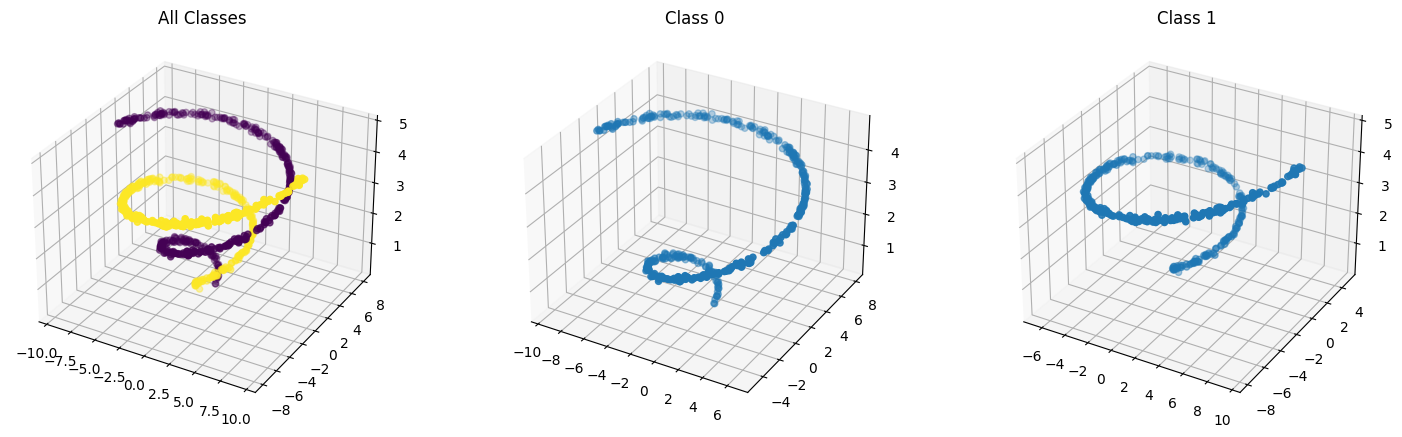

In [ ]:
# TODO: Plot original data points colored by the class labels predicted by model 1
# You can put the plot of true class labels side-by-side for comparisson.
# Optionally calculate the classification accuracy on the test set.
# Is the linear model able to effectively separate the spiral data? 
# Remember, a linear model creates a flat separating plane in this 3D space. Can you imagine where that plane might be, based on the predicted colors?

fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train)
ax1.set_title("All Classes")

ax2 = fig.add_subplot(132, projection='3d')
class_0 = torch.reshape((y_train == 0), (-1,))
ax2.scatter(X_train[class_0, 0], X_train[class_0, 1], X_train[class_0, 2])
ax2.set_title("Class 0")

ax3 = fig.add_subplot(133, projection='3d')
class_1 = torch.reshape((y_train == 1), (-1, ))
ax3.scatter(X_train[class_1, 0], X_train[class_1, 1], X_train[class_1, 2])
ax3.set_title("Class 1")

plt.show()

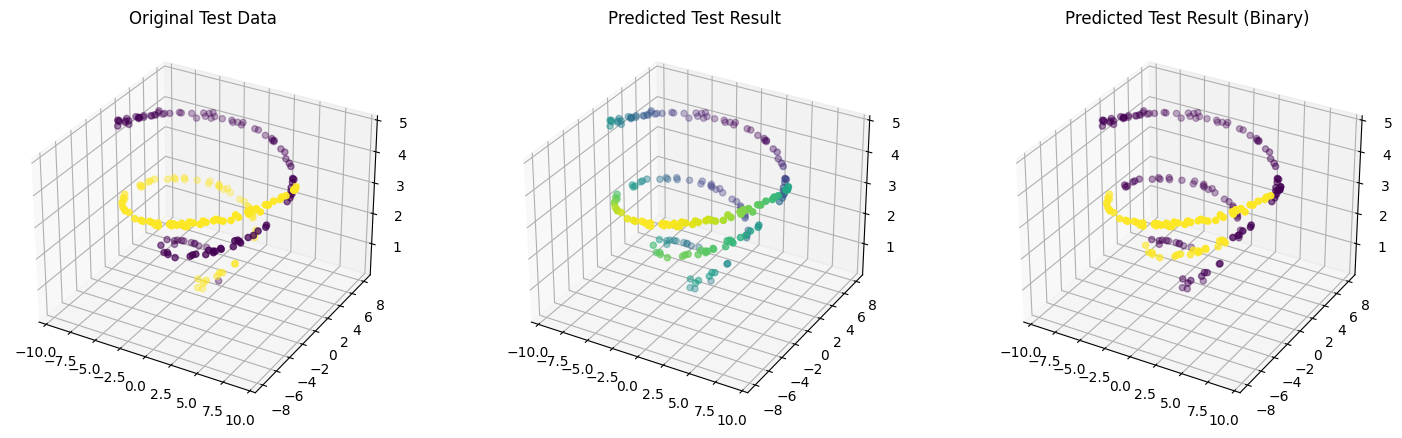

In [46]:
y_pred = model1(X_test)
y_pred = y_pred.detach().numpy()

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test)
ax1.set_title("Original Test Data")

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_pred)
ax2.set_title("Predicted Test Result")

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=(y_pred > 0.5))
ax3.set_title("Predicted Test Result (Binary)")

plt.show()

Now, let's add a hidden layer. We'll use a linear hidden layer to project the 3D data down to a 2D space *before* the final classification layer. Importantly, we will *not* use a non-linear activation function yet. The goal is to see if linear dimensionality reduction alone helps

In [ ]:
# TODO: Define the Model

# LinearHiddenModel (3 -> 3 -> 2 -> 1)
class LinearHiddenModel(nn.Module):
    """
    Modify this class to implement the 3 -> 3 -> 2 -> 1 linear architecture.
    """
    def __init__(self, hidden_dim=2): # hidden_dim might be ignored, focus on 3->3->2->1
        super().__init__()
        self.hidden_dim = hidden_dim # Store if needed

        # TODO: Define layer 1 (input=3, output=3)
        # TODO: Define layer 2 (input=3, output=2)
        # TODO: Define layer 3 (input=2, output=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Pass x through layer 1
        # TODO: Pass result through layer 2
        # TODO: Pass result through layer 3
        # TODO: Return the final output
        output = x # Placeholder, replace with correct calculation
        return output

    def get_hidden_representation(self, x: torch.Tensor) -> torch.Tensor:
        """
        Helper function to get the output AFTER the first hidden layer (the 3 -> 3 layer).
        """
        self.eval() # Ensure model is in eval mode
        with torch.no_grad(): # Disable gradient calculations
            # TODO: Calculate and return the output after layer 1
            hidden_rep = x # Placeholder, replace with correct calculation
        return hidden_rep

# --- Training Setup ---
model2 = LinearHiddenModel(hidden_dim=2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

In [ ]:
# Training loop
epochs = 2000
for epoch in tqdm(range(epochs)):
    model2.train()

    # Forward pass
    outputs = model2(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# TODO: Plot original data points colored by the class labels predicted by model 2
# Optionally calculate the classification accuracy on the test set.
# TODO: Plot the hidden representation in 2D hidden space using the helper function colored by the original and predicted class labels side-by-side.


Let's add a ReLU activation function after our hidden layer. You can implement this inheriting or modifying the previous model or defining a new model for clarity.

In [ ]:
class ReLUHiddenModel(nn.Module):
    """
    Modify this class to implement the 3 -> 3(ReLU) -> 2(ReLU) -> 1 architecture.
    """
    def __init__(self, hidden_dim=2): # hidden_dim might be ignored, focus on 3->3->2->1
        super().__init__()
        # self.hidden_dim = hidden_dim # Store if needed
        # print(f"Warning: Initializing ReLUHiddenModel for 3->3->2->1 architecture. "
        #       f"The hidden_dim={hidden_dim} argument is ignored for layer sizing.") # Optional warning

        # TODO: Define layer 1 (input=3, output=3)
        # TODO: Define the first ReLU activation function instance
        # TODO: Define layer 2 (input=3, output=2)
        # TODO: Define the second ReLU activation function instance (can be the same instance)
        # TODO: Define layer 3 (input=2, output=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Pass x through layer 1
        # TODO: Apply the first ReLU activation
        # TODO: Pass the result through layer 2
        # TODO: Apply the second ReLU activation
        # TODO: Pass the result through layer 3 (output layer)
        # TODO: Return the final output logits
        output = x # Placeholder, replace with correct calculation
        return output

    def get_hidden_representation(self, x: torch.Tensor) -> torch.Tensor:
        """
        Helper function to get the output *after* the first layer (3 -> 3)
        AND its ReLU activation function.
        """
        self.eval() # Ensure model is in eval mode
        with torch.no_grad(): # Disable gradient calculations
            # TODO: Calculate the output after layer 1
            # TODO: Apply the first ReLU activation to the layer 1 output
            # TODO: Return the activated hidden representation
            hidden_activated = x # Placeholder, replace with correct calculation
        return hidden_activated

# --- Training Setup ---
model3 = ReLUHiddenModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.01)

In [ ]:
# Training loop
epochs = 2000
for epoch in tqdm(range(epochs)):
    model3.train()

    # Forward pass
    outputs = model3(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# TODO: Plot original data points colored by the class labels predicted by model 3
# Optionally calculate the classification accuracy on the test set.
# TODO: Plot the hidden representation in 2D hidden space using the helper function colored by the original and predicted class labels side-by-side.


Compare this 2D plot (after ReLU) to the previous one (linear only). How has the representation changed?

*Optional:*
Deep learning often involves stacking multiple layers. Let's briefly see how adding another hidden layer might further refine the representation.
1. Define a model with more or larger layers.
2. Train it.
3. Visualize the output of the last hidden layer.